<a href="https://colab.research.google.com/github/profmateusmodesto/Mobile_SSD_Tomato/blob/main/analise_giroscopio_e_distancia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

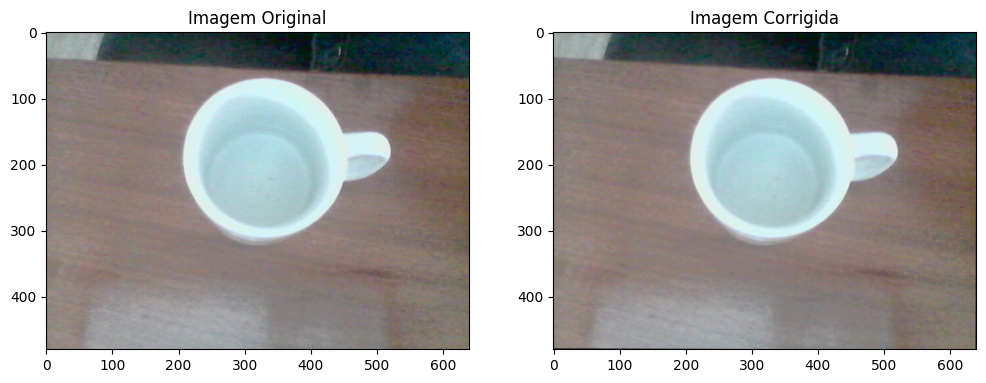

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import cv2


def corrigir_orientacao_e_distancia(taxas_angulares, tempo, distancia_focal, imagem_original):
    # Integre as taxas angulares para obter os ângulos de orientação
    angulos = np.cumsum(taxas_angulares) * (tempo[1] - tempo[0])

    # Ajuste para a orientação inicial (substitua com o valor real)
    orientacao_inicial = 0
    angulos_corrigidos = angulos - orientacao_inicial

    # Ajustar a geometria da imagem com base nos ângulos e na distância focal
    matriz_rotacao = cv2.getRotationMatrix2D((imagem_original.shape[1] / 2, imagem_original.shape[0] / 2),
                                             -angulos_corrigidos[-1], 1)
    imagem_ajustada = cv2.warpAffine(imagem_original, matriz_rotacao,
                                     (imagem_original.shape[1], imagem_original.shape[0]))

    # Ajustar a escala da imagem com base na distância focal (substitua com sua lógica específica)
    fator_escala = distancia_focal / distancia_focal_original
    largura_nova = int(imagem_original.shape[1] * fator_escala)
    altura_nova = int(imagem_original.shape[0] * fator_escala)
    imagem_ajustada = cv2.resize(imagem_ajustada, (largura_nova, altura_nova))

    # Plotar os resultados
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(imagem_original, cv2.COLOR_BGR2RGB))
    plt.title('Imagem Original')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(imagem_ajustada, cv2.COLOR_BGR2RGB))
    plt.title('Imagem Corrigida')

    plt.show(block=True)


# Exemplo de dados do giroscópio (substitua com seus próprios dados)
# taxas_angulares = np.array([0.1, 0.2, 0.15, -0.1, -0.05])
# tempo = np.array([0, 1, 2, 3, 4])

taxas_angulares = np.array([1, 1, 0.15, -1, -1])
tempo = np.array([0, 1, 2, 3, 4])


# Exemplo de distância focal (substitua com o valor real da sua câmera)
distancia_focal_original = 150.0  # Exemplo em milímetros

# Carregar uma imagem com OpenCV (substitua com o caminho da sua própria imagem)
caminho_imagem = '/content/foto_caneca_60.jpg'
imagem_original = cv2.imread(caminho_imagem)

# Chamar a função de correção de orientação e distância
corrigir_orientacao_e_distancia(taxas_angulares, tempo, distancia_focal_original, imagem_original)


Ajuste pela matrix de distorção

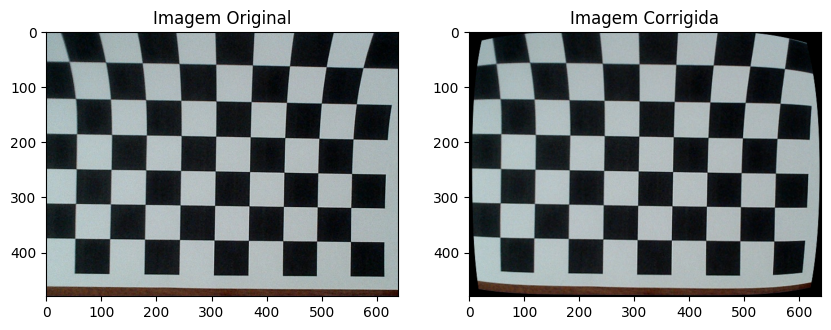

In [26]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Função para calibrar a câmera
def calibrate_camera(images, grid_size=(9, 6)):
    obj_points = []  # Pontos tridimensionais no mundo real
    img_points = []  # Pontos bidimensionais nas imagens

    # Criar coordenadas dos pontos no mundo real
    objp = np.zeros((grid_size[0] * grid_size[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:grid_size[0], 0:grid_size[1]].T.reshape(-1, 2)

    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Encontrar os cantos do tabuleiro de xadrez
        ret, corners = cv2.findChessboardCorners(gray, grid_size, None)

        if ret:
            obj_points.append(objp)
            img_points.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1], None, None)
    return ret, mtx, dist, rvecs, tvecs

# Função para corrigir distorção em uma imagem
def undistort_image(image, mtx, dist):
    undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    return undistorted

# Carregar imagens para calibrar a câmera
image_paths = ["/content/Calibracao/1.jpeg", "/content/Calibracao/2.jpeg",  "/content/Calibracao/3.jpeg", "/content/Calibracao/4.jpeg", "/content/Calibracao/5.jpeg", "/content/Calibracao/3.jpeg", "/content/Calibracao/6.jpeg"]

# Calibrar a câmera
ret, mtx, dist, rvecs, tvecs = calibrate_camera(image_paths)

# Carregar uma imagem para corrigir distorção
image_path = "/content/Calibracao/5.jpeg"
image = cv2.imread(image_path)

# Corrigir distorção
undistorted_image = undistort_image(image, mtx, dist)

# Exibir as imagens original e corrigida
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Imagem Original')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2RGB))
plt.title('Imagem Corrigida')

plt.show()